<a href="https://www.kaggle.com/code/jonbown/comparing-linear-regression-algorithms?scriptVersionId=121287034" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Three Approaches to Simple Linear Regression</center></h1>

<div align='center'>
    <img src="https://sebastianraschka.com/images/faq/gradient-optimization/ball.png"/>
</div>

> In this notebook, I will walk through the construction and implementation of simple linear regression using multiple approaches. The gradient descent algorithm will be compared to the standard linear algebra results and optimization using the Scipy package. 

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Table of Contents</center></h1>


* [Linear Regression Set Up](#chapter1)
* [Cost Function](#chapter2)
* [Gradient Descent](#chapter3)
* [Mathematical Approach](#chapter4)
* [Scipy Minimize](#chapter5)
* [Comparison](#chapter6)
* [Conclusion](#chapter7)
   

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Data</center></h1>

> The dataset in this example contains store sale data in the US. The detailed description can be found [here](https://www.kaggle.com/datasets/dsfelix/us-stores-sales)

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Problem</center></h1>

> The overall problem is predicting the 'Sales' variable from a single candidate explanatory variable. Rather than go through the exercise of determining the best explanatory variable, I will be using the 'Marketing' variable which contains the cost of marketing. In a traditional buisness environemnt, it would be intuitive to try and evaluate the effectiveness of marketing spend on sales dollars. A variable like 'inventory' might be highly correlated with sales but the cause and effect relationship may not make much sense. In order to place the empahsis of this notebook on the algorithms I am assuming that the amount of marketing spend is independent of the amount of sales that result afterward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
import time
from numpy.linalg import inv
%matplotlib inline

In [2]:
sales_df = pd.read_csv('/kaggle/input/us-stores-sales/sales.csv')

In [3]:
sales_df.head()

,Area Code,State,Market,Market Size,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Date,Product Type,Product,Type
0,203,Connecticut,East,Small Market,107.0,176.0,292.0,116.0,69.0,38.0,962.0,110.0,110.0,160.0,270.0,2,04/01/10 00:00:00,Coffee,Columbian,Regular
1,203,Connecticut,East,Small Market,75.0,135.0,225.0,90.0,60.0,29.0,1148.0,90.0,80.0,130.0,210.0,2,07/01/10 00:00:00,Coffee,Columbian,Regular
2,203,Connecticut,East,Small Market,122.0,195.0,325.0,130.0,73.0,42.0,1134.0,130.0,110.0,180.0,290.0,2,11/01/10 00:00:00,Coffee,Columbian,Regular
3,203,Connecticut,East,Small Market,105.0,174.0,289.0,115.0,69.0,37.0,1166.0,110.0,100.0,160.0,260.0,2,12/01/10 00:00:00,Coffee,Columbian,Regular
4,203,Connecticut,East,Small Market,104.0,135.0,223.0,90.0,56.0,29.0,1148.0,90.0,80.0,130.0,210.0,2,07/01/11 00:00:00,Coffee,Columbian,Regular


In [4]:
x_train = np.array(sales_df['Marketing'])
y_train = np.array(sales_df['Sales'])

In [5]:
TITLE_FONT = 15
AX_FONT = 14

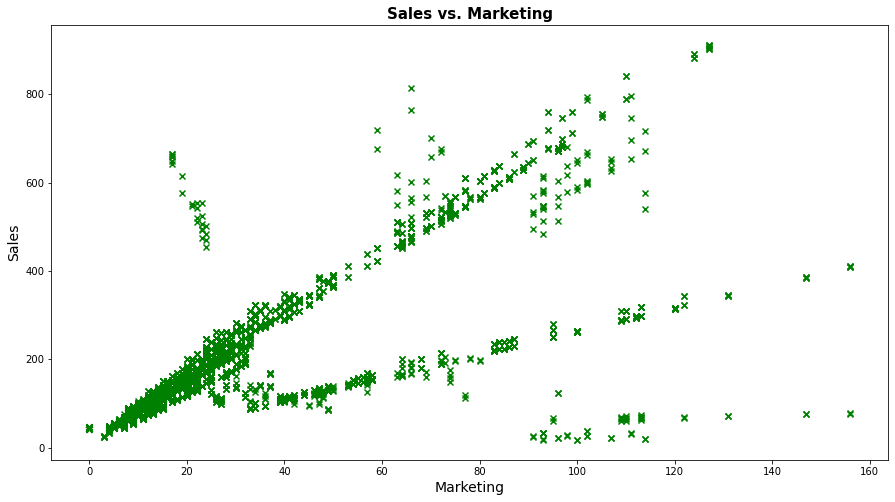

In [6]:
# Create a scatter plot of the data. To change the markers to red "x",
plt.figure(figsize=(15,8))
plt.scatter(x_train, y_train, marker='x', c='g') 
plt.title("Sales vs. Marketing", fontweight="bold", fontsize=TITLE_FONT)
plt.ylabel('Sales', fontsize=AX_FONT)
plt.xlabel('Marketing', fontsize=AX_FONT)
plt.show()

> Sure enough, we have a decent correlation between marketing and sales. Of course there are some nuances here because of the many other variables available. For simplicity I'll just stick with the entire dataset instead of subsetting on different categorical attributes.

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Linear Regression Set Up</center></h1>

The model function for simple linear regression, using the more common ML notation is represented as  

<div align='center'>
$f_{w,b}(x) = wx+b$   
</div>

To train a linear regression model, we want to find the best $w,b$ parameters that fit this dataset.

To compare how one choice of $w,b$ is better or worse than another choice, we can evaluate it with a cost function typically denoted as $J(w,b)$. The goal is to opimize this cost function using a minimzation framework. The algorithm used in this example is called gradient descent.

With each step of gradient descent, the parameters $w,b$ come closer to the optimal values that will achieve the lowest cost. The problem then becomes tuning to the appropriate step size so that the algorithm doesn't step over the optimal parameters.

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Cost Function</center></h1>

Gradient descent involves repeated steps to adjust the value of the parameters $w,b$ to gradually get a smaller and smaller cost $J(w,b)$.

At each step of gradient descent, it will be helpful for you to monitor your progress by computing the cost $J(w,b)$ as $w,b$ gets updated.

Below is a simple implementation of the cost function.

The cost function in this framework is the following:

<div align='center'>
$J(w,b) = \frac{1}{2m}\sum_{i=0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2$
</div>


In [7]:
def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
        x (ndarray): Shape (m,) Input to the model (Population of cities) 
        y (ndarray): Shape (m,) Label (Actual profits for the cities)
        w, b (scalar): Parameters of the model
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0] 
    
    total_cost = 0

    cost=0
    for i in range(m):
        f_wb = w*x[i]+b
        cost += (f_wb - y[i])**2
    
    total_cost = cost/(2*m)
    return total_cost

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Model Prediction</center></h1>

For a particular example $x^{(i)} \in R^n$ the prediction is defined as the following:

<div align='center'>
$f(x^{(i)}) = wx^{(i)} + b$
</div>

And the associated cost is 

<div align='center'>
$\text{cost}^{(i)} =  (\hat{f(x^{(i)})} - y_i)^2$
</div>

And the overall cost is thus:

<div align='center'>
$
J(w,b) = \frac{1}{2m}\sum_{i=0}^{m-1} \text{cost}^{(i)}
$
</div>

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Gradient Descent</center></h1>

The standard (sometimes called "vanilla") gradient descent algorithm is the following:

Repeat until "convergence":

<div align='center'>
$
b := b - \alpha \frac{\partial J(w,b)}{\partial b}
$
</div>
<div align='center'>
$
w := w - \alpha \frac{\partial J(w,b)}{\partial w}
$
</div>

Where

<div align='center'>
$
\frac{\partial J(w,b)}{\partial b} = \frac{1}{m}\sum_{i=0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})
$
</div>

</br>


<div align='center'>
$
\frac{\partial J(w,b)}{\partial w} = \frac{1}{m}\sum_{i=0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)}
$
</div>





In [8]:
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray): Shape (m,) Input to the model (Population of cities) 
      y (ndarray): Shape (m,) Label (Actual profits for the cities)
      w, b (scalar): Parameters of the model  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]
    
    # You need to return the following variables correctly
    dj_dw = 0
    dj_db = 0
    
    for i in range(m):
        f_wb = w*x[i]+b
        dj_db += f_wb - y[i]
        dj_dw += (f_wb - y[i])*x[i]
    dj_dw /= m
    dj_db /= m
    
    return dj_dw, dj_db

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Batch Gradient Descent</center></h1>

In [9]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x :    (ndarray): Shape (m,)
      y :    (ndarray): Shape (m,)
      w_in, b_in : (scalar) Initial values of parameters of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (ndarray): Shape (1,) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = gradient_function(x, y, w, b )  

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w, b, J_history, w_history #return w and J,w history for graphing

In [10]:
# initialize fitting parameters. Recall that the shape of w is (n,)
initial_w = 0.
initial_b = 0.

# some gradient descent settings
iterations = 1500
alpha = 0.1

w,b,_,_ = gradient_descent(x_train ,y_train, initial_w, initial_b, 
                     compute_cost, compute_gradient, alpha, iterations)
print("w,b found by gradient descent:", w, b)

Iteration    0: Cost 669870675.01   


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


Iteration  150: Cost      nan   
Iteration  300: Cost      nan   
Iteration  450: Cost      nan   
Iteration  600: Cost      nan   
Iteration  750: Cost      nan   
Iteration  900: Cost      nan   
Iteration 1050: Cost      nan   
Iteration 1200: Cost      nan   
Iteration 1350: Cost      nan   
w,b found by gradient descent: nan nan


In [11]:
alpha = 0.01

w,b,_,_ = gradient_descent(x_train ,y_train, initial_w, initial_b, 
                     compute_cost, compute_gradient, alpha, iterations)
print("w,b found by gradient descent:", w, b)

Iteration    0: Cost 6012100.35   


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in double_scalars


Iteration  150: Cost      inf   


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


Iteration  300: Cost      nan   
Iteration  450: Cost      nan   
Iteration  600: Cost      nan   
Iteration  750: Cost      nan   
Iteration  900: Cost      nan   
Iteration 1050: Cost      nan   
Iteration 1200: Cost      nan   
Iteration 1350: Cost      nan   
w,b found by gradient descent: nan nan


> Notice that for the chosen step size of $\alpha = 0.1, 0.01$ the gradient descent algorithm blows up. This is indicating that the chosen step size is too large. Because the step size is so large, the descent algorithm is 'stepping over' the part of the gradient that is headed toward the minimum. We can attempt to resolve this by decreasing the step size to $\alpha = 0.001$. 

In [12]:
%%time
alpha = 1e-3

w,b,_,_ = gradient_descent(x_train ,y_train, initial_w, initial_b, 
                     compute_cost, compute_gradient, alpha, iterations)
print("w,b found by gradient descent:", w, b)

Iteration    0: Cost 18226.02   
Iteration  150: Cost  6549.86   
Iteration  300: Cost  6441.71   
Iteration  450: Cost  6346.61   
Iteration  600: Cost  6262.99   
Iteration  750: Cost  6189.46   
Iteration  900: Cost  6124.81   
Iteration 1050: Cost  6067.96   
Iteration 1200: Cost  6017.97   
Iteration 1350: Cost  5974.01   
w,b found by gradient descent: 4.63791069794685 32.813176654091755
CPU times: user 10 s, sys: 9.06 ms, total: 10 s
Wall time: 10 s


<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Predictions</center></h1>

In [13]:
m = x_train.shape[0]
predicted = np.zeros(m)

for i in range(m):
    predicted[i] = w * x_train[i] + b

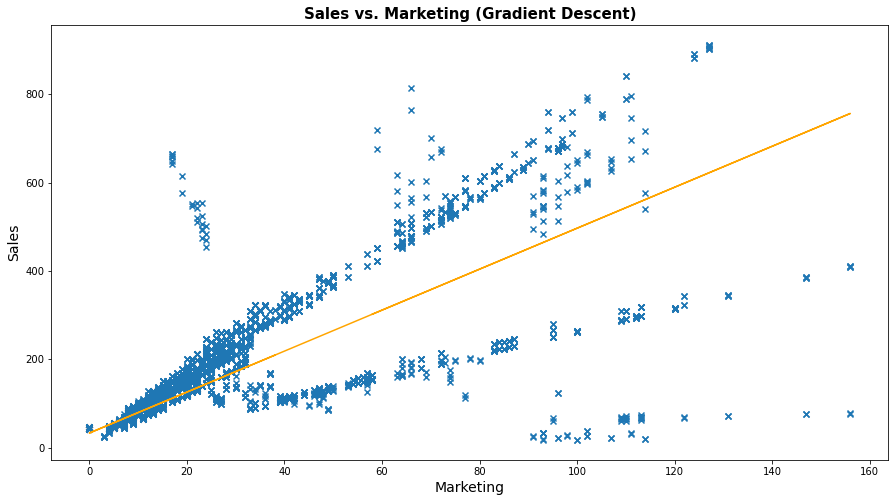

In [14]:
plt.figure(figsize=(15,8))
plt.plot(x_train, predicted, c = "orange")
plt.scatter(x_train, y_train, marker='x') 
plt.title("Sales vs. Marketing (Gradient Descent)", fontweight="bold", fontsize=TITLE_FONT)
plt.ylabel('Sales', fontsize=AX_FONT)
plt.xlabel('Marketing', fontsize=AX_FONT)
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_train, predicted)
 
GD_RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(GD_RMSE)

Root Mean Square Error:

108.95508682065129


<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Mathematical Approach (Direct Method)</center></h1>

The more common linear algebra notation for linear regression when we have a single explanatory variable together with a single dependent variable can be written as 

<div align="center">
    $Y = X\beta  + \epsilon$
</div>    

Where $Y$ is an $n \times 1$, $X$ is $n \times 2$, $\beta$ is $2 \times 1$ and $\epsilon$ is $n \times 1$

We can solve this equation directly using simple operations from linear algebra outlined below. 










<div align="center">
$(Y-X\beta)^TX = 0 \to $
</div>
<div align="center">
$X^TY-X^TX\hat{\beta} = 0 \to$
</div>
<div align="center">
$X^TY=X^TX\hat{\beta} \to $
</div>
<div align="center">
$(X^TX)^{-1}X^TY = \hat{\beta} \to $
</div>
<div align="center">
$\hat{\beta} = (X^TX)^{-1}X^TY$
</div>


In [16]:
#CONSTRUCT X
X = np.asarray([np.ones(x_train.shape[0]), x_train]).T
print(X)

[[ 1. 38.]
 [ 1. 29.]
 [ 1. 42.]
 ...
 [ 1. 49.]
 [ 1. 57.]
 [ 1. 58.]]


In [17]:
%%time
beta_0, beta_1 = inv(X.T @ X) @ X.T @ y_train
print(beta_0, beta_1)

69.06758312136631 3.9736997969445746
CPU times: user 2.17 ms, sys: 1.01 ms, total: 3.18 ms
Wall time: 3.63 ms


<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Assumptions of Linear Regression</center></h1>

## 1. The regression model is linear in the coefficients and the error term

- By the use of the linear regression model, we are by default assuming that the relationship between the independent variable and the target variable is indeed linear.

## 2. The error term has a mean of zero

- This indicates that the model is unbiased. 

## 3. All independent variables are uncorrelated with the error term

- This indicates that the independent variable cannot predict the error term and the error term is inherently random.

## 4. Observations of the error term are uncorrelated with each other

- To check this assumption we can plot the residuals vs the independent variable to see if there is a pattern. The presence of a pattern indicates that the independent variable has some predictive power over the error term.

## 5. The error term has a constant variance (no heteroscedasticity)

- The variance of the errors should be consistent for all observations. We can check this with a plot of residual vs fitted values.

## 6. No independent variable is a perfect linear function of other explanatory variables

- We don't have to worry about this one because we only have one explanatory variable and it is not perfectly correlated with the dependent variable.

## 7. The error term is normally distributed 

- This is a fundamental assumption of the linear regression model. We can check this with a simple QQ plot. 


<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Check Assumptions</center></h1>

### 4: Uncorrelated Error Term

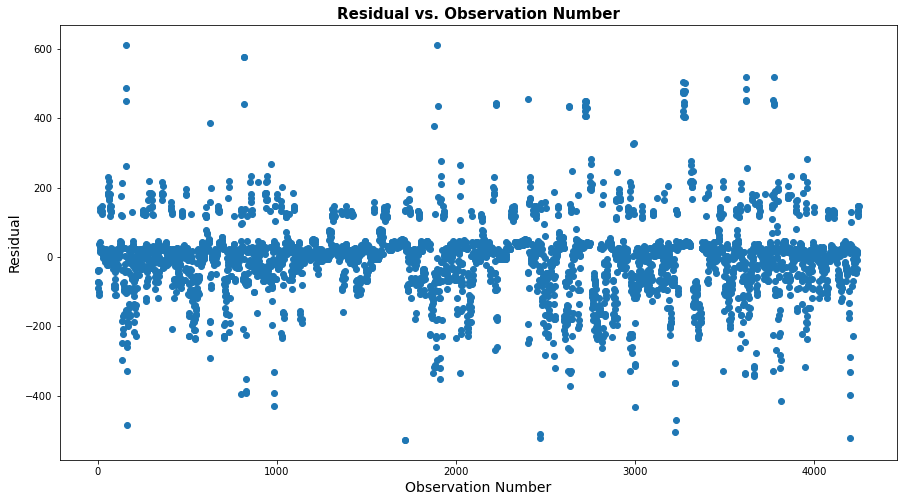

In [18]:
plt.figure(figsize=(15,8))
y_hat_solve = beta_0 + beta_1 * x_train
error = y_hat_solve - y_train
index = range(len(x_train))
plt.scatter(index, error)
plt.title('Residual vs. Observation Number', fontweight="bold", fontsize=TITLE_FONT)
plt.xlabel('Observation Number', fontsize=AX_FONT)
plt.ylabel('Residual', fontsize=AX_FONT)
plt.show()

### 5: Heteroskedasticity

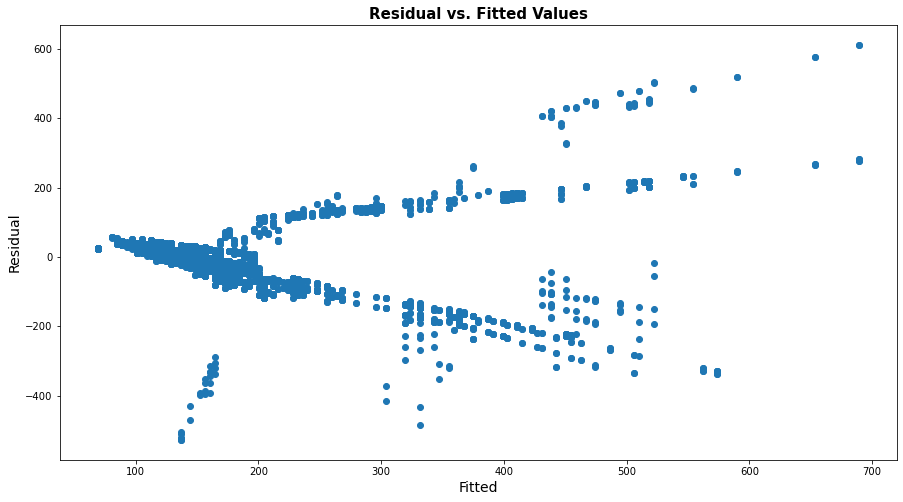

In [19]:
plt.figure(figsize=(15,8))
plt.scatter(y_hat_solve, error)
plt.title('Residual vs. Fitted Values', fontweight="bold", fontsize=TITLE_FONT)
plt.xlabel('Fitted', fontsize=AX_FONT)
plt.ylabel('Residual', fontsize=AX_FONT)
plt.show()

> There is definitely a correlation here between the residual and fitted values indicating that we don't have homoskedasticity in the error term (constant variance).

### 7: QQ Plot

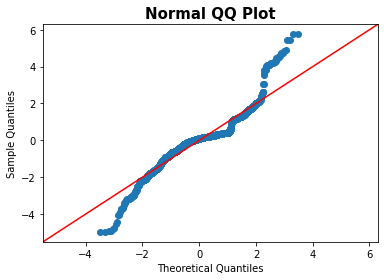

In [20]:
import statsmodels.api as sm


fig = sm.qqplot(y_hat_solve-y_train, fit=True, line='45')
plt.title('Normal QQ Plot', fontweight="bold", fontsize=TITLE_FONT)
plt.show()

> The QQ plot in the middle seems to line up with with the expected quantiles. However, the tails of this distribution diverge from expected. This is due to the fact that the data points are heavily concentrated toward the smaller values of sales and marketing. As marketing dollars increase, the expected values of sales diverge away from the line that is fit.

In [21]:
#CHECK MEAN OF RESIDUALS
round(np.mean(error),3)

-0.0

> We do have mean zero of the error term. Some important assumptions are met and there are others that make this approach somewhat questionable.

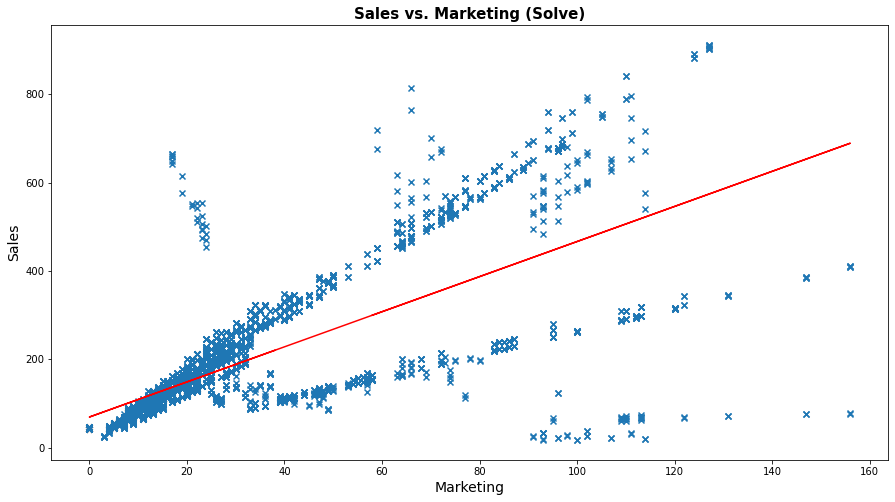

In [22]:
plt.figure(figsize=(15,8))
plt.scatter(x_train, y_train, marker='x')
plt.plot(x_train, y_hat_solve, color='r')
plt.title("Sales vs. Marketing (Solve)", fontweight="bold", fontsize=TITLE_FONT)
plt.ylabel('Sales', fontsize=AX_FONT)
plt.xlabel('Marketing', fontsize=AX_FONT)
plt.show()

In [23]:
MSE = mean_squared_error(y_train, y_hat_solve)
 
SOLVE_RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(SOLVE_RMSE)

Root Mean Square Error:

106.33716733545438


<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Scipy Minimize</center></h1>

In [24]:
from scipy.optimize import minimize
import numpy as np

# Define the Model
def f(x, w, b): return w * x + b

# The objective Function to minimize (least-squares regression)
def obj(x, y, w, b): return np.sum((y - f(x, w, b))**2)

# define the bounds -infty < a < infty,  b <= 0
bounds = [(None, None), (None, 0)]

In [25]:
%%time
# res.x contains your coefficients
res = minimize(lambda coeffs: obj(x_train, y_train, *coeffs), x0=np.zeros(2), bounds=bounds)

CPU times: user 1.57 ms, sys: 975 µs, total: 2.54 ms
Wall time: 6.08 ms


In [26]:
print(f"SCIPY: {res}")
print(f"SOLVE DIRECTLY: {beta_1}")

SCIPY:       fun: 56724181.607610635
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.49011613e+00, -2.51623243e+05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([5.23875675, 0.        ])
SOLVE DIRECTLY: 3.9736997969445746


In [27]:
res['x']

array([5.23875675, 0.        ])

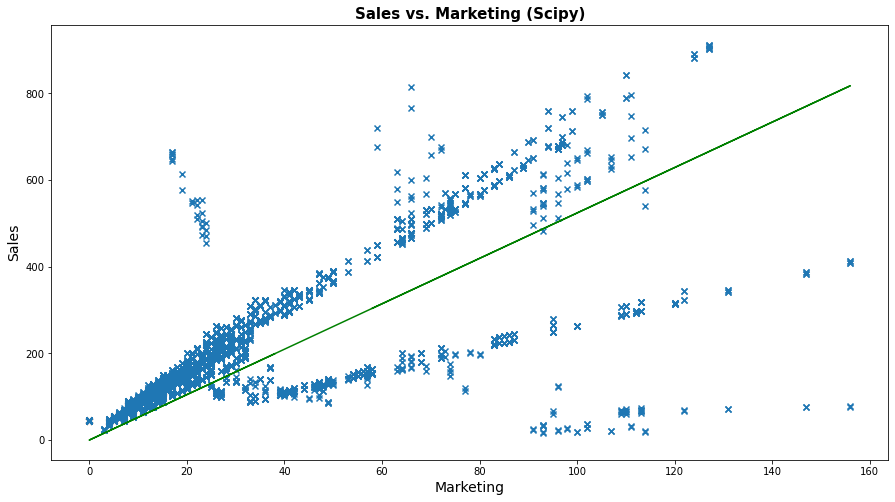

In [28]:
y_hat_sci = res['x'][1] + res['x'][0] * x_train
plt.figure(figsize=(15,8))
plt.scatter(x_train, y_train, marker='x')
plt.plot(x_train, y_hat_sci, color='g')
plt.title("Sales vs. Marketing (Scipy)", fontweight="bold", fontsize=TITLE_FONT)
plt.ylabel('Sales', fontsize=AX_FONT)
plt.xlabel('Marketing', fontsize=AX_FONT)
plt.show()

In [29]:
MSE = mean_squared_error(y_train, y_hat_sci)
 
SCI_RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(SCI_RMSE)

Root Mean Square Error:

115.55583107724827


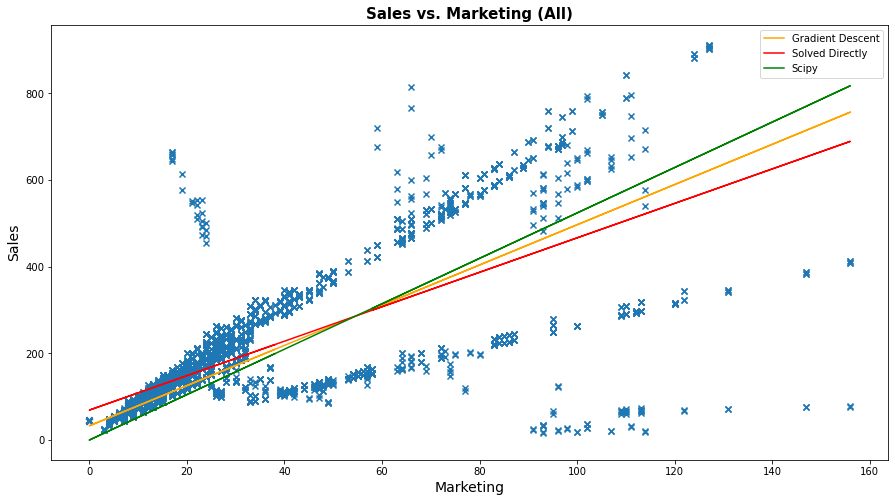

In [30]:
y_hat = res['x'][1] + res['x'][0] * x_train
plt.figure(figsize=(15,8))
plt.scatter(x_train, y_train, marker='x')
plt.plot(x_train, predicted, color='orange', label="Gradient Descent")
plt.plot(x_train, y_hat_solve, color='r', label="Solved Directly")
plt.plot(x_train, y_hat_sci, color='g', label="Scipy")
plt.title("Sales vs. Marketing (All)", fontweight="bold", fontsize=TITLE_FONT)
plt.ylabel('Sales', fontsize=AX_FONT)
plt.xlabel('Marketing', fontsize=AX_FONT)
plt.legend()
plt.show()

In [31]:
#Bar charts
rmse = [GD_RMSE, SOLVE_RMSE, SCI_RMSE]
weights = [w, beta_1, res['x'][0]]
time = [10100.0, 5.49, 8.02]
index = ['Gradient', 'Solve', 'Scipy']

data_dict = {'RMSE': rmse, 'Weights': weights, 'Runtime (ms)': time}

df = pd.DataFrame(data_dict, index=index)

In [32]:
df.head()

,RMSE,Weights,Runtime (ms)
Gradient,108.955087,4.637911,10100.00
Solve,106.337167,3.973700,5.49
Scipy,115.555831,5.238757,8.02


<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Conclusion</center></h1>

> The algorithm that performed the best among the three was clearly the direct method. This is becasue it only relies on simple matrix multiplication to find the weights and it is guaranteed to be optimal. The only problem with the direct method is the assumptions that are required. Gradient descent and the minimization algorithm in Scipy generalize much better and only require much weaker assumptions such as convexity or some type of smoothness. There are also many ways to tweak these algorithms to produce different results. The direct solving method is much more limited in where it can be applied. 

<div align="center">
<img src="https://suniljangirblog.files.wordpress.com/2018/12/1-1.gif"/>
</div>

## I hope you found this notebook interesting! Please upvote if you liked it and I genuinely welcome any feedback! 

<h1 style='background:#0dacb8;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: white;'>Sources</center></h1>

# Sources

https://statisticsbyjim.com/regression/ols-linear-regression-assumptions/

DeepLearning.AI